# Data Collection
First, collecting data from https://en.wikipedia.org/wiki/List_of_active_nationalist_parties_in_Europe and parse the table.

In [218]:
import json
import requests

def get_wiki_page (title):
    wiki_endpoint = 'https://en.wikipedia.org/w/api.php'
    payload = {
        'action': 'query',
        'format': 'json',
        'titles': title,
        'prop': 'revisions',
        'rvprop': 'content',
        'utf8': 'true'
    }
    request = requests.get(wiki_endpoint, params = payload)
    print 'GET ', request.url
    data = json.loads(request.text)
    try: 
        pages = data['query']['pages']
        page_id = pages.keys()[0]
        revisions = pages[page_id]['revisions'][0]['*']
        if ('#REDIRECT' in revisions):
            pattern = r'\[\[(.*?)\]\]'
            original_title =  re.findall(pattern, revisions)[0]
            print 'Redirecting to', original_title
            return get_wiki_page(original_title)
        return data
    except KeyError:
        return data


In [19]:
# wikitables from https://github.com/bcicen/wikitables is used to 
# quickly and easily get the contents of the tables on the page

list_name = 'List of active nationalist parties in Europe'

from wikitables import import_tables
tables = import_tables(list_name)
parties = tables[0].rows
print 'Keys for every party'
for key in parties[0].keys():
    print ' - ', key
print tables[0].name 
for row in parties:
    print ' - ', row['Country'], ':', row['Party']

Keys for every party
 -  Votes
 -  % of popular vote
 -  Europarty
 -  Country
 -  Ideology, description
 -  Seats
 -  Party
 -  Date established
List of active nationalist parties in Europe[0]
 -  Armenia : Republican Party of Armenia
 -  Hungary : Fidesz
 -  Macedonia : VMRO-DPMNE
 -  Poland : Law and Justice
 -  Switzerland : Swiss People's Party
 -  Austria : Freedom Party of Austria
 -  Denmark : Danish People's Party
 -  Belgium : New Flemish Alliance
 -  Hungary : Jobbik
 -  Finland : Finns Party
 -  Italy : Lega Nord
 -  Latvia : National Alliance
 -  Norway : Progress Party
 -  Ireland : Sinn Féin
 -  France : National Front
 -  Netherlands : Party for Freedom
 -  Netherlands : Forum for Democracy
 -  Sweden : Sweden Democrats
 -  Germany : Alternative for Germany
 -  Russia : LDPR
 -  Norway : Centre Party
 -  Slovakia : Slovak National Party
 -  Estonia : Conservative People's Party of Estonia
 -  Serbia : Serbian Radical Party
 -  Slovakia : Kotleba - People’s Party Our Slo

Now that we have the contents of the table containing all the listed parties and some basic stats about them (country, number of votes etc.), we can go into the page for every party and fetch the contents. From this we'll try to parse out any non-trivial links (navigation and headers and so on) and try to build a network out of these.

In [219]:
import re

blacklist = [
    'Category',
    'list',
    'file:',
    'wiktionary:'
]

def processLink(link):
    decoded = link.encode('utf-8')
    split = re.split(r'[(|]+', decoded)
    return split[0]

def checkLink(link):
    return any(substring.lower() in link.lower() for substring in blacklist)

def getWikiLinks(text):
    pattern = r'\[\[(.*?)\]\]'
    links = re.findall(pattern, text)
    processed = [processLink(link) for link in links]
    return [link for link in processed if not checkLink(link)]

def clean_name(name):
    for ch in [' ', '-']:
        name = name.replace(ch, '_')
    for ch in [",", ".",'–']:
        name = name.replace(ch, '')
    return name.lower().decode('utf-8').encode('ascii', 'replace')

for i, party in enumerate(parties):
    party = dict(party)
    party_name = str(party['Party'])
    party_title = clean_name(party_name)
    party['title'] = party_title
    print 'Party name:', party_name
    pages_json = get_wiki_page(party_name)
    pages = pages_json['query']['pages']
    for key in pages.keys():
        try:
            text = pages[key]['revisions'][0]['*']
            party['links'] = list(set(getWikiLinks(text)))
            print 'Found', len(party['links']), 'links'
        except:
            print '--------- Failed to fetch text for', party_name
            party['links'] = []
            continue
    parties[i] = party    


Party name: Republican Party of Armenia
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Republican+Party+of+Armenia&action=query
Found 59 links
Party name: Fidesz
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Fidesz&action=query
Found 97 links
Party name: VMRO-DPMNE
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=VMRO-DPMNE&action=query
Found 70 links
Party name: Law and Justice
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Law+and+Justice&action=query
Found 151 links
Party name: Swiss People's Party
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Swiss+People%27s+Party&action=query
Found 137 links
Party name: Freedom Party of Austria
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles

GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Croatian+Party+of+Rights+dr.+Ante+Star%C4%8Devi%C4%87&action=query
Redirecting to Croatian Party of Rights Dr. Ante Starčević
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Croatian+Party+of+Rights+Dr.+Ante+Star%C4%8Devi%C4%87&action=query
Found 37 links
Party name: Croatian Pure Party of Rights
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Croatian+Pure+Party+of+Rights&action=query
Found 54 links
Party name: Slovenian National Party
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Slovenian+National+Party&action=query
Found 65 links
Party name: Right Sector
GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Right+Sector&action=query
Found 157 links
Party name: United Kingdom Independence 

With all data collected as a list of parties with the links from their pages stored within, two networks are constructed. One that where edges are created when a party's page's links contain another party directly (first order), and one where the edges consist of two party's that have a common link (second order). The latter will have the link stored on the edge attribute.

In [220]:
import networkx as nx

# initialize multiple graphs
graph_first = nx.Graph()
graph_scnd = nx.Graph()


for party in parties:
    # add nodes to both graphs
    graph_first.add_node(party['title'], **dict(party))
    graph_scnd.add_node(party['title'], **dict(party))

    
for i, party in enumerate(parties):
    links = party['links']
    for link in links:
        clean_link = clean_name(link)
        # add an edge if a page of one party mentions another to 'first'
        if graph_first.has_node(clean_link):
            graph_first.add_edge(clean_link, party['title'])
        for j, party2 in enumerate(parties):
            # add an edge if two party's pages have a link in commonn to 'second'
            if i != j:
                links2 = party2['links']
                for link2 in links2:
                    if link == link2 and not graph_scnd.has_edge(party2['title'], party['title']):
                        graph_scnd.add_edge(party2['title'], party['title'], link=link)

Some very basic visualization of these graphs.

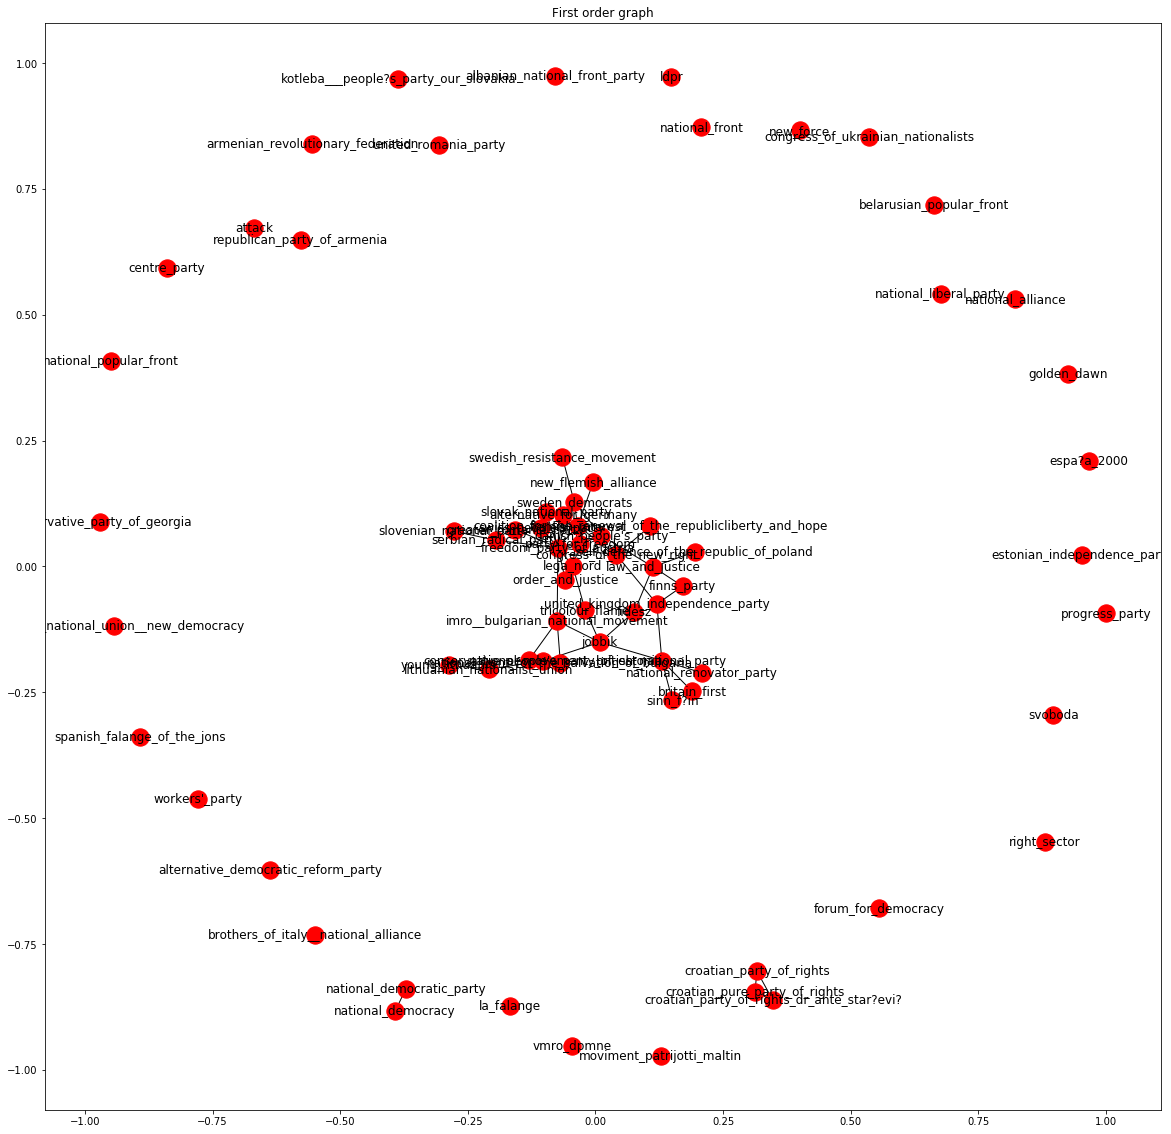

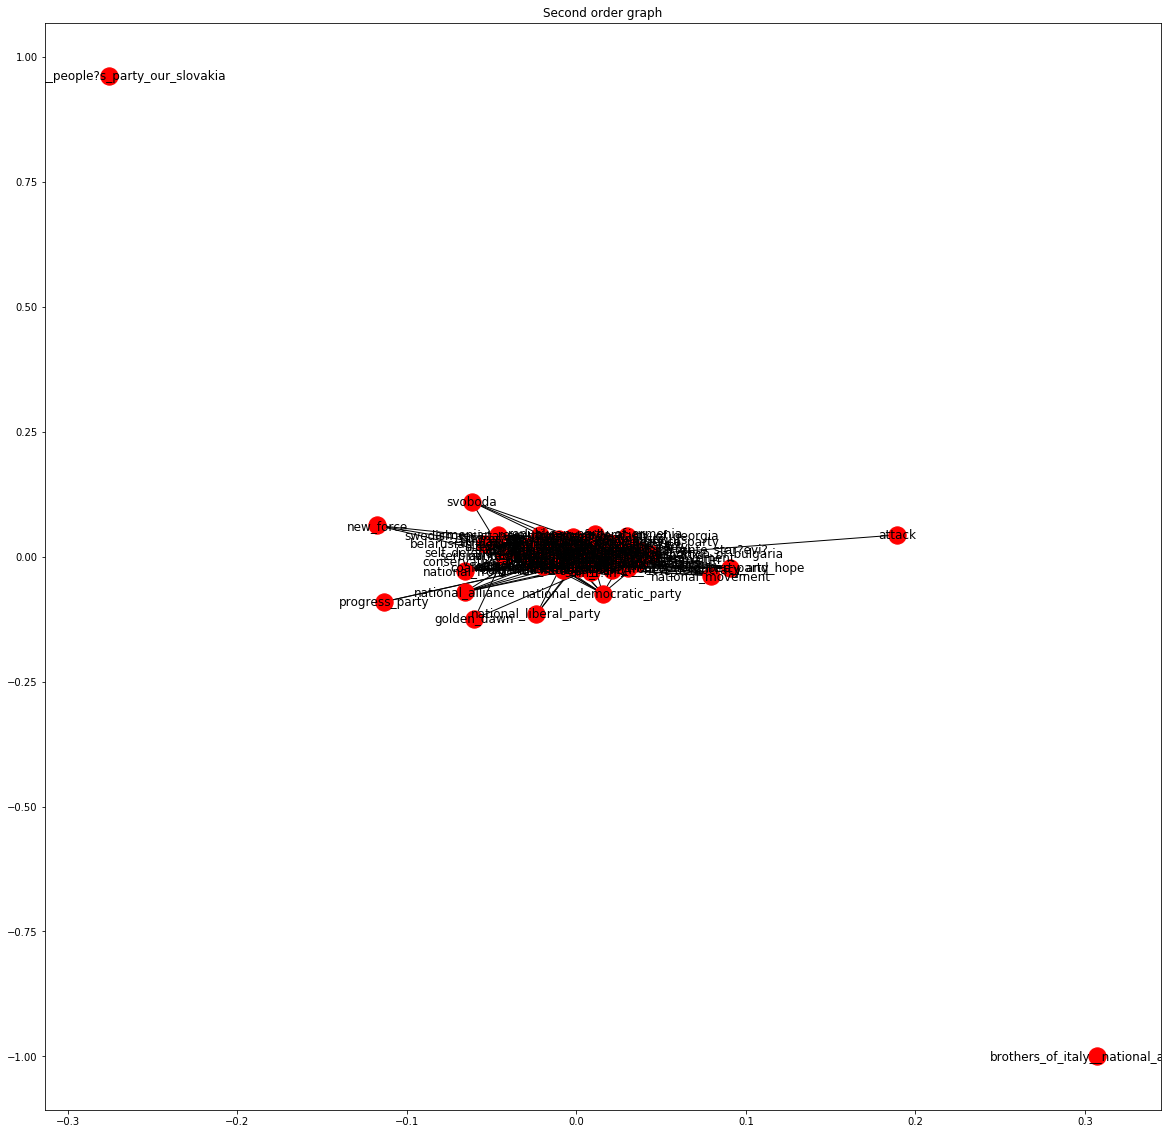

In [221]:
import matplotlib.pyplot as plt
%matplotlib inline

# try:
#     import pygraphviz
#     from networkx.drawing.nx_agraph import graphviz_layout
#     layout = graphviz_layout
# except ImportError:
#     print 'No graphviz'
#     try:
#         import pydot
#         from networkx.drawing.nx_pydot import graphviz_layout
#         layout = graphviz_layout
#     except ImportError:
#         print("PyGraphviz and pydot not found;\n"
#               "drawing with spring layout;\n"
#               "will be slow.")
layout = nx.spring_layout

figure = plt.figure(figsize=(20, 20))
plt.title('First order graph')
pos = layout(graph_first)
nx.draw_networkx(graph_first, pos, with_labels=True)

figure = plt.figure(figsize=(20, 20))
pos = layout(graph_scnd)
plt.title('Second order graph')
nx.draw_networkx(graph_scnd, pos, with_labels=True)





# Basic Stats
We'll have a look at some basic stats for the graphs, like their size in terms of nodes and edges, the size of the GCC and the degree distribution.

Graph 1
Number of nodes: 70
Number of edges: 52
The average degree of the network is 1.4857142857142858
The median degree of the network is 1.0
Number of nodes in GCC: 34
Graph 2
Number of nodes: 70
Number of edges: 1452
The average degree of the network is 41.48571428571429
The median degree of the network is 50.0
Number of nodes in GCC: 68


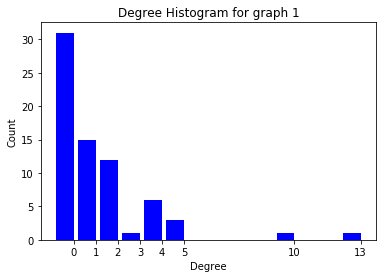

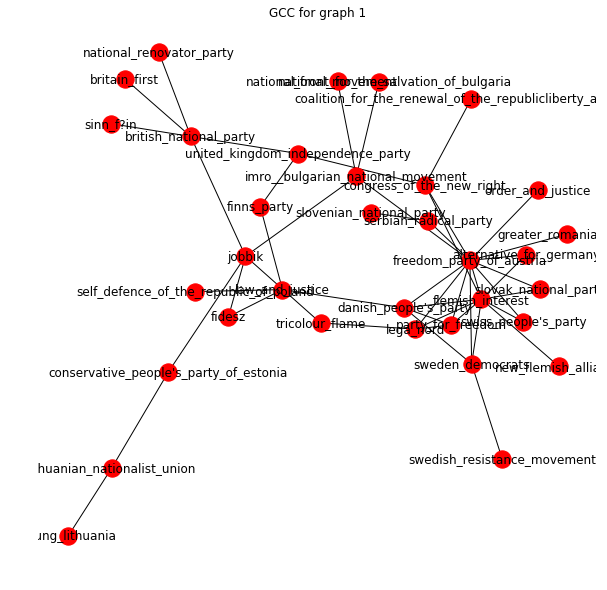

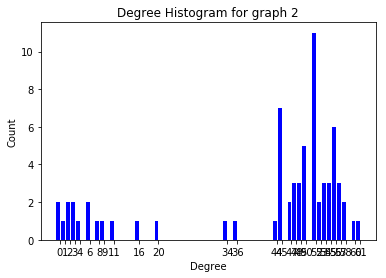

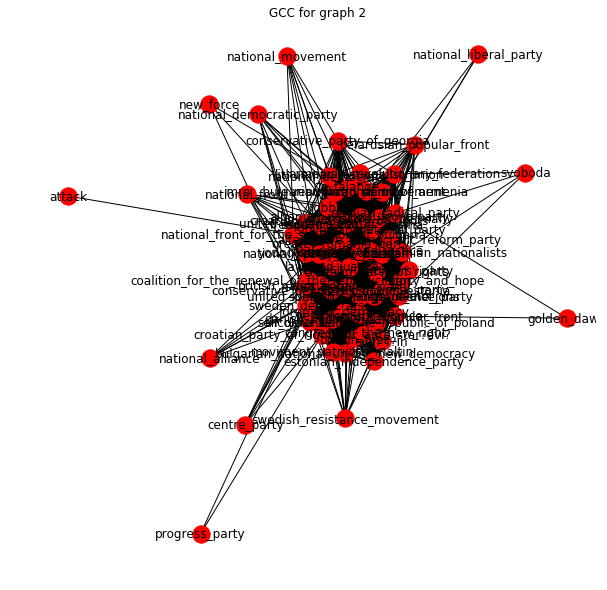

In [222]:
import numpy as np
from collections import Counter

for i, graph in enumerate([graph_first, graph_scnd]):
    print 'Graph', i + 1
    print 'Number of nodes:', len(graph.nodes)
    print 'Number of edges:', len(graph.edges)
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  # degree sequence
    degreeCount = Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())    
    
    print 'The average degree of the network is', np.average(degree_sequence)
    print 'The median degree of the network is', np.median(degree_sequence)
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram for graph {}".format(i + 1))
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)
    Gcc = sorted(nx.connected_component_subgraphs(graph), key=len, reverse=True)
    G0 = Gcc[0]
    print 'Number of nodes in GCC:', len(G0.nodes)
    fig = plt.figure(figsize=(10, 10))
    plt.title('GCC for graph {}'.format(i + 1))
    pos = layout(G0)
    nx.draw(G0, pos, with_labels=True)


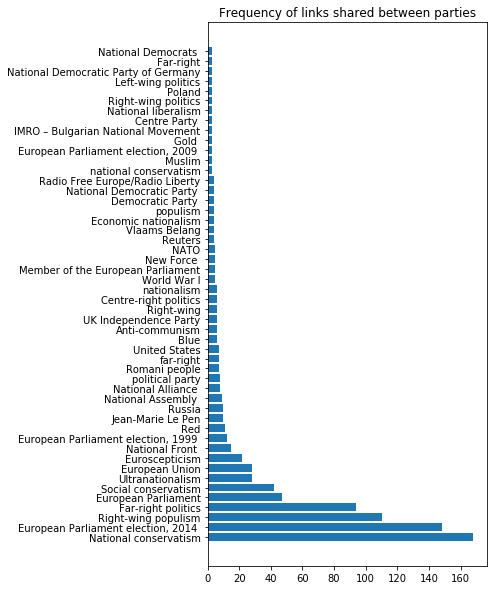

In [187]:
links = sorted(nx.get_edge_attributes(graph_scnd, 'link').values())
links = [link.decode('utf-8') for link in links]
link_counts = Counter(links)


lnk, cnt = zip(*link_counts.most_common(50)) 
fig = plt.figure(figsize=(5, 10))

plt.barh(range(len(lnk)),cnt)
plt.yticks(range(len(lnk)),lnk)
plt.title('Frequency of links shared between parties')
plt.show()


[(u'National conservatism',
  u'European Parliament election, 2014 ',
  u'Right-wing populism',
  u'Far-right politics',
  u'European Parliament'),
 (168, 148, 110, 94, 47)]

In [193]:
node_links = nx.get_node_attributes(graph_first, 'links')
print node_links['flemish_interest']

['Vlaams Belang']


GET  https://en.wikipedia.org/w/api.php?format=json&utf8=true&rvprop=content&prop=revisions&titles=Flemish+Interest&action=query
{
  "batchcomplete": "", 
  "query": {
    "pages": {
      "1181436": {
        "ns": 0, 
        "pageid": 1181436, 
        "revisions": [
          {
            "*": "#REDIRECT [[Vlaams Belang]]\n\n{{Redirect category shell|1=\n{{R from alternative language|en|und}}\n}}", 
            "contentmodel": "wikitext", 
            "contentformat": "text/x-wiki"
          }
        ], 
        "title": "Flemish Interest"
      }
    }
  }
}


TypeError: list indices must be integers, not str